In [1]:
import os
import json
import glob
import copy

import numpy as np
import pandas as pd
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator, MultipleLocator
import cartopy.crs as ccrs
import cartopy as cart
from cartopy.util import add_cyclic_point
import seaborn as sns

mpl.rcParams.update({'font.size': 12})

Load in data

In [2]:
def ext(cube,region):
    """Extract region from cube."""
    return cube.intersection(longitude=(region[0], region[2]), latitude=(region[1], region[3]))


def prepare_for_merge(cube, realization):
    """Prepare cube for merging, for ensemble statistics."""
    cube.var_name = 'n_gb_mean'
    realization_coord = iris.coords.AuxCoord(np.int32(realization), "realization", units="1")
    try:
        cube.add_aux_coord(realization_coord)
    except Exception as e:
        pass
    return cube


def area_avg_cube(cube):
    """Calculate an area-weighted average of cube."""
    if type(cube) == iris.cube.Cube:
        if not cube.coord('latitude').has_bounds():
            cube.coord('latitude').guess_bounds()
        if not cube.coord('longitude').has_bounds():
            cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)
        
        new_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    
    else:
        raise TypeError('Function only accepts cubes')
    
    return new_cube


def get_ensemble_statistics(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
    for p in cubes_c1:
        realization = 0
        for c1 in cubes_c1[p]:
            c1 = prepare_for_merge(c1, realization)
            realization += 1
        realization = 0
        for c2 in cubes_c2[p]:
            c2 = prepare_for_merge(c2, realization)
            realization += 1
        realization = 0
        for c3 in cubes_c3[p]:
            c3 = prepare_for_merge(c3, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]

    return stats

def get_regional_stats(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][0], region))
        area_mean['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][0], region))
        area_mean['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][0], region))
        
        area_med['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][1], region))
        area_med['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][1], region))
        area_med['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][1], region))
        
        area_max['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][2], region))
        area_max['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][2], region))
        area_max['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][2], region))
        
        area_min['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][3], region))
        area_min['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][3], region))
        area_min['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][3], region))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_frac(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][0][:, :5]), region))
        area_mean['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][0][:, :5]), region))
        area_mean['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][0][:, :5]), region))
        
        area_med['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][1][:, :5]), region))
        area_med['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][1][:, :5]), region))
        area_med['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][1][:, :5]), region))
        
        area_max['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][2][:, :5]), region))
        area_max['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][2][:, :5]), region))
        area_max['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][2][:, :5]), region))
        
        area_min['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][3][:, :5]), region))
        area_min['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][3][:, :5]), region))
        area_min['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][3][:, :5]), region))
        
    return [area_mean, area_med, area_max, area_min]


# time series plots
def plot_single_timeseries(area_list, conv, region, title=None, ylabel=None):
    font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12,
        }

    matplotlib.rc('font', **font)
    area, area_med, area_max, area_min = area_list
    time = np.arange(1990, 2110, 10)
    decs = len(time)

    nrows = 1
    ncols = 6
    X = [ ((1,5)), (6,6)]
    fig = plt.figure(figsize=(8,6))

    ### --- subfig 1
    sub1 = fig.add_subplot(nrows, ncols, X[0])
    sub1.set_title(title)
    sub1.set_ylabel(ylabel)
    sub1.set_xlim(np.min(time), 2105)
    #sub.set_ylim(-3,2)
    # c1
    sub1.plot(time, area_med['c1']['0.5'][-decs:].data*conv - 295.59, 'blue', linewidth=2, label=f'C1: IMP-Ren')
    sub1.fill_between(time, area_med['c1']['0.01'][-decs:].data*conv - 295.59, area_med['c1']['0.99'][-decs:].data*conv - 295.59, color='blue', alpha=0.2)
    # c2
    sub1.plot(time, area_med['c2']['0.5'][-decs:].data*conv - 295.59, 'red', linewidth=2, label=f'C2: IMP-Neg')
    sub1.fill_between(time, area_med['c2']['0.01'][-decs:].data*conv - 295.59, area_med['c2']['0.99'][-decs:].data*conv - 295.59, color='red', alpha=0.2)
    # c3
    sub1.plot(time, area['c3']['0.5'][-decs:].data*conv - 295.59, 'cyan', linewidth=3, label=f'C3: IMP-GS')
    sub1.fill_between(time, area['c3']['0.01'][-decs:].data*conv - 295.59, area['c3']['0.99'][-decs:].data*conv - 295.59, color='cyan', alpha=0.2)

    sub1.legend(loc="upper left",frameon=False,prop={'size': 10})

    ### --- subfig 2
    sub2 = fig.add_subplot(nrows, ncols, X[1])
    sub2.set_xlim(0,4)
    sub2.set_xticks([1, 2, 3])
    sub2.set_xticklabels(["C1", "C2", "C3"])
    sub2.set_yticklabels("")

    # c1
    sub2.plot([1, 1], [area_min['c1']['0.5'][-1].data*conv - 295.59, area_max['c1']['0.5'][-1].data*conv - 295.59], 'blue', lw=10, alpha=0.2)
    sub2.scatter(1, np.double(area_med['c1']['0.5'][-1].data*conv - 295.59), marker=',', color='blue')
    # c2
    sub2.plot([2, 2], [area_min['c2']['0.5'][-1].data*conv - 295.59, area_max['c2']['0.5'][-1].data*conv - 295.59], 'red', lw=10, alpha=0.2)
    sub2.scatter(2, np.double(area_med['c2']['0.5'][-1].data*conv - 295.59), marker=',', color='red')
    # c3
    sub2.plot([3, 3], [area_min['c3']['0.5'][-1].data*conv - 295.59, area_max['c3']['0.5'][-1].data*conv - 295.59], 'cyan', lw=10, alpha=0.2)
    sub2.scatter(3, np.double(area['c3']['0.5'][-1].data*conv - 295.59), marker=',', color='cyan')

    # set y-limits for both subplots (makes sure that subplots have equal y-axis limits and that that it fits the uncertainty ranges of both subplots)
    if (abs(np.ptp(sub1.get_ylim())) > abs(np.ptp(sub2.get_ylim()))):   # if first subplot's ylim greater than the second
        ylim = sub1.get_ylim()
    else:
        ylim = sub2.get_ylim()
    sub1.set_ylim(ylim)
    sub2.set_ylim(ylim)
    
    fname = area['c1']['0.5'].var_name
    plt.savefig(f'{os.getcwd()[:-9]}/plots/{fname}_{region}_CSSP.png', dpi=500)
    
def zeroed_levels_cmap(
    vmin: float, 
    vmax: float, 
    vstep: int, 
    cmap: str='RdBu_r'
):
    vmid = 0.0
    if vmin == 0:
        vmin = -1e-12 # Set to smol number so contours don't break
    vrange=[vmin, vmax]
    levels = np.arange(vrange[0], vrange[1]+vstep, vstep)
    ncols = len(levels) -1 

    deltamax = max(vrange[1]-vmid, vmid-vrange[0]) 
    vfull = [ vmid-deltamax, vmid+deltamax] # Full range either side of vmid

    # We'll map 0-1 to vfull[0]--vfull[1]   (size: 2*deltamax), 
    # so we need to know how far along vrange[0] and vrange[1] are.
    vlo_frac = (vrange[0]-vfull[0]) / (2.0*deltamax) # 0 or greater
    vhi_frac = (vrange[1]-vfull[0]) / (2.0*deltamax) # 1 or less
    # (one of these two must be 0 or 1)

    cmap_base = plt.get_cmap(cmap) # maps the range 0-1 to colours
    cols = cmap_base( np.linspace( vlo_frac, vhi_frac, ncols) )
    cmap = mpl.colors.LinearSegmentedColormap.from_list('skewed',cols, N=ncols)

#     cmap.set_under(color='royalblue', alpha=0.2)
#     cmap.set_over(color='black')
    
    return levels, cmap

In [1]:
# Gets parent directory
fair_dict_path = '/home/h03/hadea/roses/u-bd604_gmtchange_es_2300/bin/fair_2300_dict.json'
data_path = "/scratch/hadea/imogen_post/imogen6/u-bd604_gmtchange_es_2300_ens_new"

with open(fair_dict_path) as f:
    fair_dict = json.load(f)

percentiles = ['0.01', '0.5', '0.99']
scenarios = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
# variables = ['t1p5m_gb','npp_n_gb','resp_s_to_atmos_gb', 'gpp_gb','runoff','frac','cv']
variables = ['t1p5m_gb', 'npp_n_gb', 'frac']
t1p5m_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
npp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
# resp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
# gpp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
# runoff_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
frac_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
# cs_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
# cv_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}

for root, dirs, files in os.walk(data_path):
    for file in files:
        for scenario in scenarios:
            for p in percentiles:
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[0]}_ens.nc')):
                    t1p5m_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[1]}_ens.nc')):
                    npp_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[2]}_ens.nc')):
                    frac_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
       

NameError: name 'json' is not defined

Useful functions + Amazon and Boreal area definitions

In [4]:
time_coord = t1p5m_cubes['C1-IMP-Ren']['0.01'][0].coord('time')
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if not scen == 'ssprcmip_ssp534_over':
                t1p5m_cubes[scen][p][i].remove_coord('time')
                t1p5m_cubes[scen][p][i].add_dim_coord(time_coord, 0)
                
                npp_cubes[scen][p][i].remove_coord('time') 
                npp_cubes[scen][p][i].add_dim_coord(time_coord, 0)
                
                frac_cubes[scen][p][i].remove_coord('time')
                frac_cubes[scen][p][i].add_dim_coord(time_coord, 0)
            
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if model.attributes['source'].split('/')[6].split('_')[0] in ['NorESM2-LM', 'KACE-1-0-G', 'E3SM-1-0']: # FIO-ESM only in temporarily, as is missing for NPP only
                t1p5m_cubes[scen][p].pop(i)
                frac_cubes[scen][p].pop(i)
                npp_cubes[scen][p].pop(i)    

In [5]:
# define region. Allows running notebook for different regions

region = {
    "amazon": [-90,-40,-15,10],
    "amazon_map": [-105,-35,-15,10],
    "siberia": [45, 45, 135, 80],
    "siberia_map": [45, 40, 135, 85],
    "global": [-180, -90, 180, 90]
}

In [6]:
%%capture
npp_stats = get_ensemble_statistics(npp_cubes)
t1p5m_stats = get_ensemble_statistics(t1p5m_cubes)
frac_stats = get_ensemble_statistics(frac_cubes)

Merges cubelist for ensemble statistics

Calculate area averages for timeseries plots

In [7]:
%%capture
npp_area_list_amazon = get_regional_stats(npp_stats, region=region['amazon'])
t1p5m_area_list_amazon = get_regional_stats(t1p5m_stats, region=region['amazon'])
frac_area_list_amazon = get_regional_stats_frac(frac_stats, region=region['amazon'])

npp_area_list_siberia = get_regional_stats(npp_stats, region=region['siberia'])
t1p5m_area_list_siberia = get_regional_stats(t1p5m_stats, region=region['siberia'])
frac_area_list_siberia = get_regional_stats_frac(frac_stats, region=region['siberia'])

Plot timeseries of variable over amazon basin

In [8]:
# calculate amazon grid area
area_cube = iris.load_cube(f'{os.getcwd()[:-9]}/gmtchange_es_area.nc')
amazon_area = np.sum(ext(area_cube, region['amazon']).data) * 1e6 # km2 = m2
siberia_area = np.sum(ext(area_cube, region['siberia']).data) * 1e6 # km2 = m2
amazon_conv = amazon_area / 1e12 # conv: kg m-2 y-1 -> PgC
siberia_conv = siberia_area / 1e12 # conv: kg m-2 y-1 -> PgC

In [9]:
scens = ['c1', 'c2', 'c3']
time = np.arange(2000, 2300, 10)
decs = len(time)

##### Calculate regional temp anomaly

In [10]:
# Calculate regional temperature anomaly 1850-1900
temp_median_amazon = t1p5m_area_list_amazon[0]
regional_temp_anomaly_amazon = {'c1': {}, 'c2': {}, 'c3': {}}
scens = ['c1', 'c2', 'c3']
for scen in scens:
    for p in percentiles:
        regional_temp_anomaly_amazon[scen][p] = temp_median_amazon[scen][p][:5].collapsed('time', iris.analysis.MEAN)
        
temp_median_siberia = t1p5m_area_list_siberia[1]
regional_temp_anomaly_siberia = {'c1': {}, 'c2': {}, 'c3': {}}
scens = ['c1', 'c2', 'c3']
for scen in scens:
    for p in percentiles:
        regional_temp_anomaly_siberia[scen][p] = temp_median_siberia[scen][p][:5].collapsed('time', iris.analysis.MEAN)

/home/h04/gmunday/.conda/envs/fair-ukesm/lib/python3.10/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/h04/gmunday/.conda/envs/fair-ukesm/lib/python3.10/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coordinates with 2 bounds. Metadata may not be fully descriptive for 'time'. Ignoring bounds.
  warnings.warn(msg.format(str(exc), self.name()))
/home/h04/gmunday/.conda/envs/fair-ukesm/lib/python3.10/site-packages/iris/coords.py:2226: UserWarning: Cannot check if coordinate is contiguous: Invalid operation for 'time', with 0 bound(s). Contiguous bounds are only defined for 1D coord

In [11]:
def calculate_overshoot_peak(regional_var):
    val = np.max(regional_var)
    index = np.argmax(regional_var)
    
    return index, val

In [12]:
# Calculating Amazon overshoot peaks
temp_median_amazon_peak_index_c1, temp_median_amazon_peak_c1 = calculate_overshoot_peak(temp_median_amazon['c1']['0.5'][-decs:].data - regional_temp_anomaly_amazon['c1']['0.5'].data)
temp_median_amazon_peak_index_c2, temp_median_amazon_peak_c2 = calculate_overshoot_peak(temp_median_amazon['c2']['0.5'][-decs:].data - regional_temp_anomaly_amazon['c2']['0.5'].data)
temp_median_amazon_peak_index_c3, temp_median_amazon_peak_c3 = calculate_overshoot_peak(temp_median_amazon['c3']['0.5'][-decs:].data - regional_temp_anomaly_amazon['c3']['0.5'].data)

# Calculating Siberia overshoot peaks
temp_median_siberia_peak_index_c1, temp_median_siberia_peak_c1 = calculate_overshoot_peak(temp_median_siberia['c1']['0.5'][-decs:].data - regional_temp_anomaly_siberia['c1']['0.5'].data)
temp_median_siberia_peak_index_c2, temp_median_siberia_peak_c2 = calculate_overshoot_peak(temp_median_siberia['c2']['0.5'][-decs:].data - regional_temp_anomaly_siberia['c2']['0.5'].data)
temp_median_siberia_peak_index_c3, temp_median_siberia_peak_c3 = calculate_overshoot_peak(temp_median_siberia['c3']['0.5'][-decs:].data - regional_temp_anomaly_siberia['c3']['0.5'].data)

# Calculating Global overshoot peaks
temp_median_global_peak_index_c1, temp_median_global_peak_c1 = calculate_overshoot_peak(ren_temp)
temp_median_global_peak_index_c2, temp_median_global_peak_c2 = calculate_overshoot_peak(neg_temp)
temp_median_global_peak_index_c3, temp_median_global_peak_c3 = calculate_overshoot_peak(gs_temp)

NameError: name 'ren_temp' is not defined

In [16]:
temp_median_amazon_anomaly_c1 = temp_median_amazon['c1']['0.5'][-decs:].data - regional_temp_anomaly_amazon['c1']['0.5'].data
temp_median_amazon_anomaly_c2 = temp_median_amazon['c2']['0.5'][-decs:].data - regional_temp_anomaly_amazon['c2']['0.5'].data
temp_median_amazon_anomaly_c3 = temp_median_amazon['c3']['0.5'][-decs:].data - regional_temp_anomaly_amazon['c3']['0.5'].data

temp_median_siberia_anomaly_c1 = temp_median_siberia['c1']['0.5'][-decs:].data - regional_temp_anomaly_siberia['c1']['0.5'].data
temp_median_siberia_anomaly_c2 = temp_median_siberia['c2']['0.5'][-decs:].data - regional_temp_anomaly_siberia['c2']['0.5'].data
temp_median_siberia_anomaly_c3 = temp_median_siberia['c3']['0.5'][-decs:].data - regional_temp_anomaly_siberia['c3']['0.5'].data

In [17]:
frac_baseline_amazon = 0.4049183403189171
frac_baseline_siberia = 0.2549000854052015
npp_baseline_amazon = 9.834009253483387
npp_baseline_siberia = 2.5685072983979635

In [18]:
scens = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
        
npp_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        npp_area_mean['amazon'][scen][p] = ext(npp_stats[scen][p][0]*amazon_conv, region['amazon'])
        npp_area_mean['siberia'][scen][p] = ext(npp_stats[scen][p][0]*siberia_conv, region['siberia'])
        npp_area_mean['amazon_map'][scen][p] = ext(npp_stats[scen][p][0]*amazon_conv, region['amazon_map'])
        npp_area_mean['siberia_map'][scen][p] = ext(npp_stats[scen][p][0]*siberia_conv, region['siberia_map'])
        
frac_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        frac_area_mean['amazon'][scen][p] = ext(frac_stats[scen][p][0], region['amazon'])  
        frac_area_mean['siberia'][scen][p] = ext(frac_stats[scen][p][0], region['siberia'])     
        frac_area_mean['amazon_map'][scen][p] = ext(frac_stats[scen][p][0], region['amazon_map'])  
        frac_area_mean['siberia_map'][scen][p] = ext(frac_stats[scen][p][0], region['siberia_map'])    

temp_area_mean = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'amazon_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia_map': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        temp_area_mean['amazon'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['amazon'])
        temp_area_mean['siberia'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['siberia'])
        temp_area_mean['amazon_map'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['amazon_map'])
        temp_area_mean['siberia_map'][scen][p] = ext(t1p5m_stats[scen][p][0]-273.15, region['siberia_map'])

#### Plot figure 2

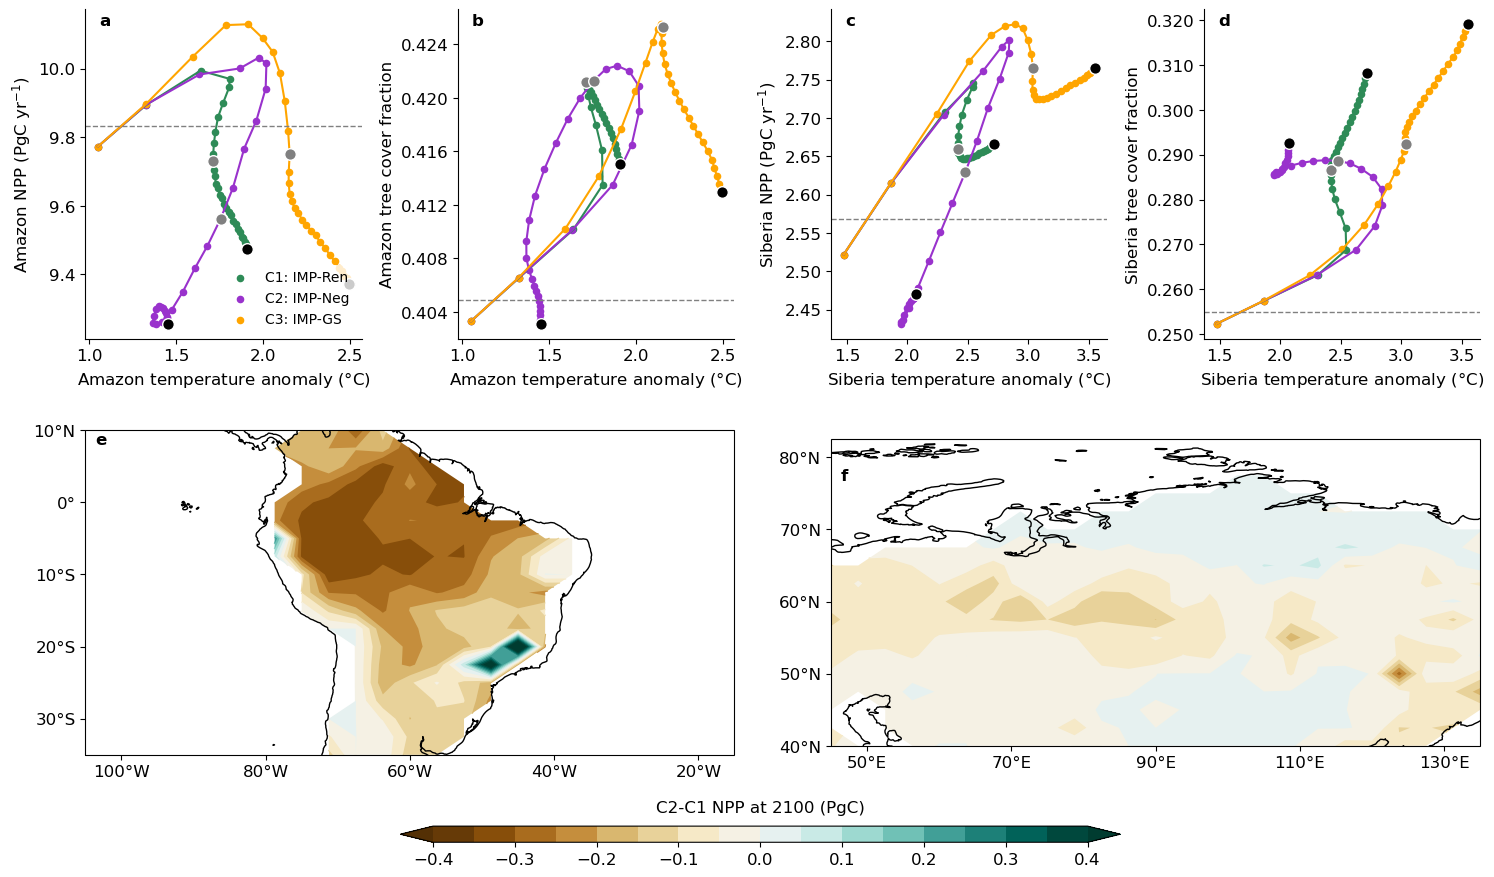

In [19]:
overshoot_peak_ms = 70
linealpha=1
lineps=20
endofline_size=70

frac_mean_amazon = frac_area_list_amazon[0]
npp_mean_amazon = npp_area_list_amazon[0]
frac_mean_siberia = frac_area_list_siberia[0]
npp_mean_siberia = npp_area_list_siberia[0]

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

levels = np.arange(-0.4,0.45,0.05)

X = [ (1,1), (2,2), (3,3), (4,4),
      (5,6),        (7,8)]


fig = plt.figure(figsize=(18, 8.5))

ax = fig.add_subplot(2, 4, X[1])
# ax.set_title('Amazon Tree fraction')
ax.scatter(temp_median_amazon_anomaly_c1, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', label="C1: IMP-Ren", s=lineps)
ax.plot(temp_median_amazon_anomaly_c1, np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c2, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', label="C2: IMP-Neg", s=lineps)
ax.plot(temp_median_amazon_anomaly_c2, np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c3, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', label="C3: IMP-GS", s=lineps)
ax.plot(temp_median_amazon_anomaly_c3, np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_amazon_anomaly_c1[-20], np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c2[-20], np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c3[-20], np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_amazon_anomaly_c1[-1], np.sum(frac_mean_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c2[-1], np.sum(frac_mean_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c3[-1], np.sum(frac_mean_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.set_ylabel('Amazon tree cover fraction')

ax.axhline(frac_baseline_amazon, linestyle='--', lw=1, color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')

ax = fig.add_subplot(2, 4, X[0])
# ax.set_title('Amazon NPP')
ax.scatter(temp_median_amazon_anomaly_c1, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', s=lineps, label="C1: IMP-Ren")
ax.plot(temp_median_amazon_anomaly_c1, npp_mean_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c2, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', s=lineps, label="C2: IMP-Neg")
ax.plot(temp_median_amazon_anomaly_c2, npp_mean_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_amazon_anomaly_c3, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', s=lineps, label="C3: IMP-GS")
ax.plot(temp_median_amazon_anomaly_c3, npp_mean_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', alpha=linealpha)

# Plot overshoot peak
ax.scatter(temp_median_amazon_anomaly_c1[-20], npp_mean_amazon['c1']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c2[-20], npp_mean_amazon['c2']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_amazon_anomaly_c3[-20], npp_mean_amazon['c3']['0.5'][-decs:].data[-20]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_amazon_anomaly_c1[-1], npp_mean_amazon['c1']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c2[-1], npp_mean_amazon['c2']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_amazon_anomaly_c3[-1], npp_mean_amazon['c3']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Amazon temperature anomaly ($\degree$C)')
ax.set_ylabel('Amazon NPP (PgC yr$^{-1}$)')

ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')

ax.spines[['right', 'top']].set_visible(False)
ax.axhline(npp_baseline_amazon, linestyle='--', lw=1, color='grey')

plt.legend(loc='lower right', edgecolor='none', prop={'size': 10})

ax = fig.add_subplot(2, 4, X[3])
# ax.set_title('Siberia Tree fraction')
ax.scatter(temp_median_siberia_anomaly_c1, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', s=lineps)
ax.plot(temp_median_siberia_anomaly_c1, np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c2, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', s=lineps)
ax.plot(temp_median_siberia_anomaly_c2, np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c3, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', s=lineps)
ax.plot(temp_median_siberia_anomaly_c3, np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_siberia_anomaly_c1[-20], np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c2[-20], np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c3[-20], np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-20], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_siberia_anomaly_c1[-1], np.sum(frac_mean_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c2[-1], np.sum(frac_mean_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c3[-1], np.sum(frac_mean_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.set_ylabel('Siberia tree cover fraction')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(frac_baseline_siberia, linestyle='--', lw=1, color='grey')

ax = fig.add_subplot(2, 4, X[2])
# ax.set_title('Siberia NPP')
ax.scatter(temp_median_siberia_anomaly_c1, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', s=lineps)
ax.plot(temp_median_siberia_anomaly_c1, npp_mean_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c2, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', s=lineps)
ax.plot(temp_median_siberia_anomaly_c2, npp_mean_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', alpha=linealpha)
ax.scatter(temp_median_siberia_anomaly_c3, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', s=lineps)
ax.plot(temp_median_siberia_anomaly_c3, npp_mean_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', alpha=linealpha)

# Plot 2100 points
ax.scatter(temp_median_siberia_anomaly_c1[-20], npp_mean_siberia['c1']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c2[-20], npp_mean_siberia['c2']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_siberia_anomaly_c3[-20], npp_mean_siberia['c3']['0.5'][-decs:].data[-20]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(temp_median_siberia_anomaly_c1[-1], npp_mean_siberia['c1']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c2[-1], npp_mean_siberia['c2']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(temp_median_siberia_anomaly_c3[-1], npp_mean_siberia['c3']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Siberia temperature anomaly ($\degree$C)')
ax.set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(npp_baseline_siberia, linestyle='--', lw=1, color='grey')
     
# Now plot the maps
    
ax = fig.add_subplot(2, 4, X[4], projection=ccrs.PlateCarree())
# ax.add_feature(cart.feature.OCEAN, zorder=9, edgecolor='k', facecolor="none")
ax.coastlines()

cont = iplt.contourf(
    npp_area_mean['amazon_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['amazon_map']['C1-IMP-Ren']['0.5'][-20], 
    cmap='BrBG', 
    levels=levels, 
    extend='both'
)

ax.set_xticks([-100, -80, -60, -40, -20], crs=ccrs.PlateCarree())
ax.set_xticklabels(['100°W', '80°W', '60°W', '40°W', '20°W'])
ax.set_yticks([-30, -20, -10, 0, 10], crs=ccrs.PlateCarree())
ax.set_yticklabels(['30°S', '20°S', '10°S', '0°', '10°N'])
ax.annotate("e", xy=(0.015, 0.97), xycoords='axes fraction', weight='bold', ha='left', va='center',color="black",zorder=10)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(2, 4, X[5], projection=ccrs.PlateCarree())
# ax.add_feature(cart.feature.OCEAN, zorder=9, edgecolor='k', facecolor="none")
ax.coastlines()

cont = iplt.contourf(
    npp_area_mean['siberia_map']['C2-IMP-Neg']['0.5'][-20] - npp_area_mean['siberia_map']['C1-IMP-Ren']['0.5'][-20], 
    cmap='BrBG', 
    levels=levels, 
    extend='both'
)

ax.set_xticks([50, 70, 90, 110, 130], crs=ccrs.PlateCarree())
ax.set_xticklabels(['50°E', '70°E', '90°E', '110°E', '130°E'])
ax.set_yticks([40, 50, 60, 70, 80], crs=ccrs.PlateCarree())
ax.set_yticklabels(['40°N', '50°N', '60°N', '70°N', '80°N'])
ax.annotate("f", xy=(0.015, 0.88), xycoords='axes fraction', weight='bold', ha='left', va='center',color="black",zorder=10) 
ax.spines[['right', 'top']].set_visible(False)

cbar_ax = fig.add_axes([0.3, -0.1, 0.4, 0.019])
fig.colorbar(cont, cax=cbar_ax, orientation='horizontal')
fig.text(0.5,-0.065,"C2-C1 NPP at 2100 (PgC)",ha="center")
fig.subplots_adjust(wspace=0.35, hspace=0.27,bottom=0.0)
    
# plt.tight_layout()
plt.savefig(f'../paper_plots/fig2_regional_Norman_2100.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()

#### Now plot with global temps

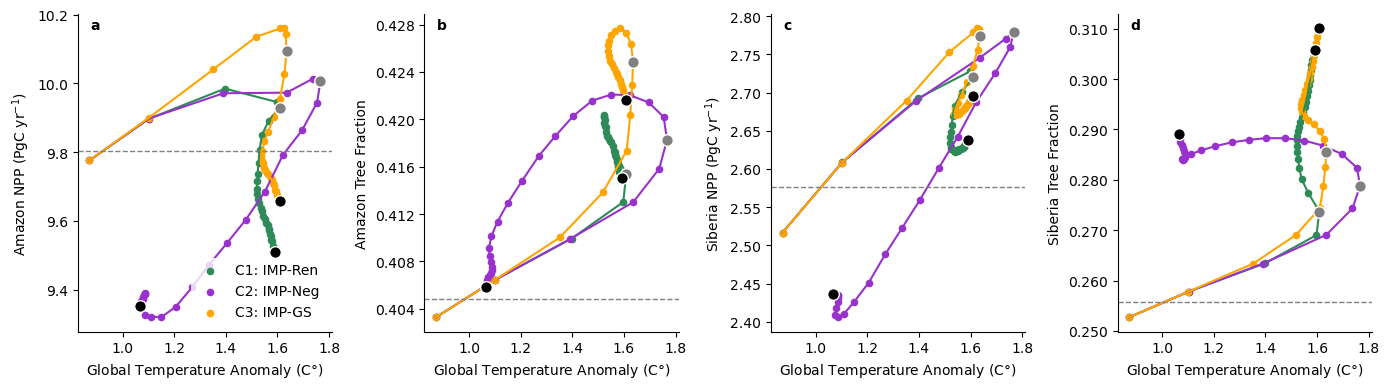

In [36]:
overshoot_peak_ms = 70
linealpha=1
lineps=20
endofline_size=70

frac_med_amazon = frac_area_list_amazon[1]
npp_med_amazon = npp_area_list_amazon[1]
frac_med_siberia = frac_area_list_siberia[1]
npp_med_siberia = npp_area_list_siberia[1]

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

fig = plt.figure(figsize=(14, 4))
# plt.suptitle('ECS 50$^{th}$ percentile, ESM Distribution Medians')

ax = fig.add_subplot(1, 4, 2)
# ax.set_title('Amazon Tree fraction')
ax.scatter(ren_temp, np.sum(frac_med_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', label="C1: IMP-Ren", s=lineps)
ax.plot(ren_temp, np.sum(frac_med_amazon['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(neg_temp, np.sum(frac_med_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', label="C2: IMP-Neg", s=lineps)
ax.plot(neg_temp, np.sum(frac_med_amazon['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(gs_temp, np.sum(frac_med_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', label="C3: IMP-GS", s=lineps)
ax.plot(gs_temp, np.sum(frac_med_amazon['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_global_peak_c1, np.sum(frac_med_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[temp_median_global_peak_index_c1], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c2, np.sum(frac_med_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[temp_median_global_peak_index_c2], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c3, np.sum(frac_med_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[temp_median_global_peak_index_c3], color='grey', edgecolor='white', marker='o', zorder=2, s=overshoot_peak_ms)

ax.scatter(ren_temp[-1], np.sum(frac_med_amazon['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(neg_temp[-1], np.sum(frac_med_amazon['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(gs_temp[-1], np.sum(frac_med_amazon['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Global Temperature Anomaly (C$\degree$)')
ax.set_ylabel('Amazon Tree Fraction')

ax.axhline(frac_baseline_amazon, linestyle='--', lw=1, color='grey')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'b', transform=ax.transAxes, color='black', weight='bold')

ax = fig.add_subplot(1, 4, 1)
# ax.set_title('Amazon NPP')
ax.scatter(ren_temp, npp_med_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', s=lineps, label="C1: IMP-Ren")
ax.plot(ren_temp, npp_med_amazon['c1']['0.5'][-decs:].data*amazon_conv, color='seagreen', alpha=linealpha)
ax.scatter(neg_temp, npp_med_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', s=lineps, label="C2: IMP-Neg")
ax.plot(neg_temp, npp_med_amazon['c2']['0.5'][-decs:].data*amazon_conv, color='darkorchid', alpha=linealpha)
ax.scatter(gs_temp, npp_med_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', s=lineps, label="C3: IMP-GS")
ax.plot(gs_temp, npp_med_amazon['c3']['0.5'][-decs:].data*amazon_conv, color='orange', alpha=linealpha)

# Plot overshoot peak
ax.scatter(temp_median_global_peak_c1, npp_med_amazon['c1']['0.5'][-decs:].data[temp_median_global_peak_index_c1]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c2, npp_med_amazon['c2']['0.5'][-decs:].data[temp_median_global_peak_index_c2]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c3, npp_med_amazon['c3']['0.5'][-decs:].data[temp_median_global_peak_index_c3]*amazon_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(ren_temp[-1], npp_med_amazon['c1']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(neg_temp[-1], npp_med_amazon['c2']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(gs_temp[-1], npp_med_amazon['c3']['0.5'][-decs:].data[-1]*amazon_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Global Temperature Anomaly (C$\degree$)')
ax.set_ylabel('Amazon NPP (PgC yr$^{-1}$)')

ax.text(0.05, 0.95, 'a', transform=ax.transAxes, color='black', weight='bold')

ax.spines[['right', 'top']].set_visible(False)
ax.axhline(npp_baseline_amazon, linestyle='--', lw=1, color='grey')

plt.legend(loc='lower right', edgecolor='none')

ax = fig.add_subplot(1, 4, 4)
# ax.set_title('Siberia Tree fraction')
ax.scatter(ren_temp, np.sum(frac_med_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', s=lineps)
ax.plot(ren_temp, np.sum(frac_med_siberia['c1']['0.5'][-decs:, :5].data, axis=1), color='seagreen', alpha=linealpha)
ax.scatter(neg_temp, np.sum(frac_med_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', s=lineps)
ax.plot(neg_temp, np.sum(frac_med_siberia['c2']['0.5'][-decs:, :5].data, axis=1), color='darkorchid', alpha=linealpha)
ax.scatter(gs_temp, np.sum(frac_med_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', s=lineps)
ax.plot(gs_temp, np.sum(frac_med_siberia['c3']['0.5'][-decs:, :5].data, axis=1), color='orange', alpha=linealpha)

# Plot overshoot peaks + ends
ax.scatter(temp_median_global_peak_c1, np.sum(frac_med_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[temp_median_global_peak_index_c1], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c2, np.sum(frac_med_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[temp_median_global_peak_index_c2], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c3, np.sum(frac_med_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[temp_median_global_peak_index_c3], color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(ren_temp[-1], np.sum(frac_med_siberia['c1']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(neg_temp[-1], np.sum(frac_med_siberia['c2']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(gs_temp[-1], np.sum(frac_med_siberia['c3']['0.5'][-decs:, :5].data, axis=1)[-1], color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Global Temperature Anomaly (C$\degree$)')
ax.set_ylabel('Siberia Tree Fraction')

ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax.yaxis.set_major_locator(MultipleLocator(0.004))
ax.yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'd', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(frac_baseline_siberia, linestyle='--', lw=1, color='grey')

ax = fig.add_subplot(1, 4, 3)
# ax.set_title('Siberia NPP')
ax.scatter(ren_temp, npp_med_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', s=lineps)
ax.plot(ren_temp, npp_med_siberia['c1']['0.5'][-decs:].data*siberia_conv, color='seagreen', alpha=linealpha)
ax.scatter(neg_temp, npp_med_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', s=lineps)
ax.plot(neg_temp, npp_med_siberia['c2']['0.5'][-decs:].data*siberia_conv, color='darkorchid', alpha=linealpha)
ax.scatter(gs_temp, npp_med_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', s=lineps)
ax.plot(gs_temp, npp_med_siberia['c3']['0.5'][-decs:].data*siberia_conv, color='orange', alpha=linealpha)

# Plot overshoot peak
ax.scatter(temp_median_global_peak_c1, npp_med_siberia['c1']['0.5'][-decs:].data[temp_median_global_peak_index_c1]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c2, npp_med_siberia['c2']['0.5'][-decs:].data[temp_median_global_peak_index_c2]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)
ax.scatter(temp_median_global_peak_c3, npp_med_siberia['c3']['0.5'][-decs:].data[temp_median_global_peak_index_c3]*siberia_conv, color='grey', marker='o', edgecolor='white', zorder=2, s=overshoot_peak_ms)

ax.scatter(ren_temp[-1], npp_med_siberia['c1']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(neg_temp[-1], npp_med_siberia['c2']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)
ax.scatter(gs_temp[-1], npp_med_siberia['c3']['0.5'][-decs:].data[-1]*siberia_conv, color='black', marker='o', edgecolor='white', zorder=2, s=endofline_size)

ax.set_xlabel('Global Temperature Anomaly (C$\degree$)')
ax.set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

ax.spines[['right', 'top']].set_visible(False)
ax.text(0.05, 0.95, 'c', transform=ax.transAxes, color='black', weight='bold')

ax.axhline(npp_baseline_siberia, linestyle='--', lw=1, color='grey')
            
plt.tight_layout()
plt.savefig(f'../paper_plots/fig2_ad_global.png', dpi=500)
plt.show()
plt.close()

#### Plot NPP maps of each region

In [17]:
scens = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
        
npp_area_med = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        npp_area_med['amazon'][scen][p] = ext(npp_stats[scen][p][1]*amazon_conv, region['amazon'])
        npp_area_med['siberia'][scen][p] = ext(npp_stats[scen][p][1]*amazon_conv, region['siberia'])
        
        
frac_area_med = {
    'amazon': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
        },
    'siberia': {
        'C1-IMP-Ren': {}, 'C2-IMP-Neg': {}, 'C3-IMP-GS': {}
    }
}
for scen in scens:
    for p in percentiles:
        frac_area_med['amazon'][scen][p] = ext(frac_stats[scen][p][1], region['amazon'])
        frac_area_med['siberia'][scen][p] = ext(frac_stats[scen][p][1], region['siberia'])

In [18]:
npp_diff_amazon = npp_area_med['amazon']['C2-IMP-Neg']['0.5'][-1] - npp_area_med['amazon']['C1-IMP-Ren']['0.5'][-1]
npp_diff_siberia = npp_area_med['siberia']['C2-IMP-Neg']['0.5'][-1] - npp_area_med['siberia']['C1-IMP-Ren']['0.5'][-1]

In [19]:
cmap_min = min(np.min(npp_diff_amazon.data), np.min(npp_diff_siberia.data))
cmap_max = max(np.max(npp_diff_amazon.data), np.max(npp_diff_siberia.data))

npp_levels, npp_cmap = zeroed_levels_cmap(-1.2, 2.0, 0.2, cmap='BrBG')

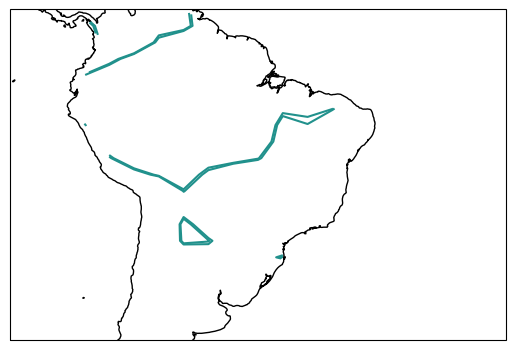

In [103]:
frac_2300 = frac_area_med['amazon']['C2-IMP-Neg']['0.5'][-1, 0].copy(data=np.sum(frac_area_med['amazon']['C2-IMP-Neg']['0.5'][-1, :5].data, axis=0))
frac_2100 = frac_area_med['amazon']['C2-IMP-Neg']['0.5'][-1, 0].copy(data=np.sum(frac_area_med['amazon']['C2-IMP-Neg']['0.5'][-20, :5].data, axis=0))
iplt.contour(frac_2300, levels=1)
iplt.contour(frac_2100, levels=1)
plt.gca().coastlines()

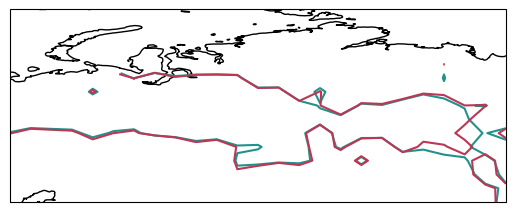

In [108]:
frac_2300 = frac_area_med['siberia']['C2-IMP-Neg']['0.5'][-1, 0].copy(data=np.sum(frac_area_med['siberia']['C2-IMP-Neg']['0.5'][-1, :5].data, axis=0))
frac_2100 = frac_area_med['siberia']['C2-IMP-Neg']['0.5'][-1, 0].copy(data=np.sum(frac_area_med['siberia']['C2-IMP-Neg']['0.5'][-20, :5].data, axis=0))
iplt.contour(frac_2300, levels=1)
iplt.contour(frac_2100, levels=1, cmap='inferno')
plt.gca().coastlines()

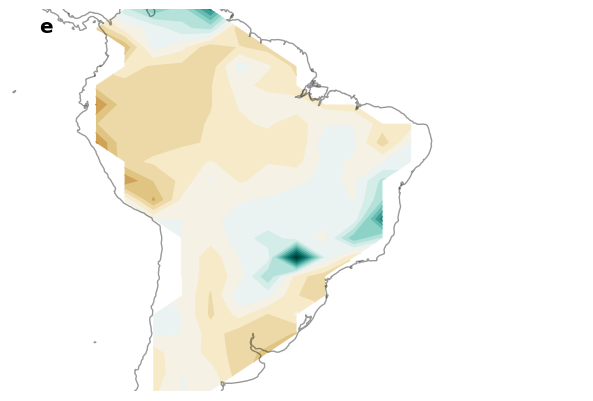

In [20]:
fig = plt.figure(figsize=(12, 6))

projection = ccrs.PlateCarree()

# Plot WBGT
ax = fig.add_subplot(121, projection=projection)
ax.coastlines(resolution='50m', alpha=0.4)

im = iplt.contourf(npp_diff_amazon, npp_levels, cmap=npp_cmap, extend='both')

ax.axis('off')
ax.text(0.05, 0.94, 'e', transform=ax.transAxes, color='black', weight='bold', fontsize='large')

plt.tight_layout()
plt.savefig('../paper_plots/fig2_e', dpi=400)

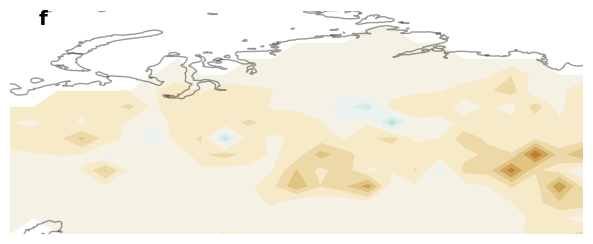

In [21]:
fig = plt.figure(figsize=(12, 12))

projection = ccrs.PlateCarree()

ax = fig.add_subplot(121, projection=projection)
ax.coastlines(resolution='50m', alpha=0.4)

im = iplt.contourf(npp_diff_siberia, npp_levels, cmap=npp_cmap, extend='both') 

ax.axis('off')
ax.text(0.05, 0.94, 'f', transform=ax.transAxes, color='black', weight='bold', fontsize='large')


plt.tight_layout()
plt.savefig('../paper_plots/fig2_f', dpi=400)

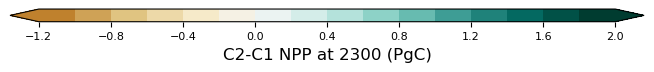

In [24]:
fig = plt.figure(figsize=(18, 6))

projection = ccrs.PlateCarree()

# Plot WBGT
ax = fig.add_subplot(121, projection=projection)
plt.gca().set_visible(False)
# Add nice colourbar
divider = make_axes_locatable(ax)
ax2 = divider.new_vertical(
    size="4%", pad=0.3, axes_class=plt.Axes, pack_start=True
)  # creates 2nd axis
fig.add_axes(ax2)
cbar = plt.colorbar(
    im, cax=ax2, orientation="horizontal"
)  # puts colour bar on second axis
cbar.ax.set_xlabel(f"C2-C1 NPP at 2300 (PgC)")  # labels colour bar
cbar.ax.tick_params(labelsize=8)

plt.savefig('../paper_plots/fig2_colorbar.png', dpi=400)